In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
file_path = "C:/Users/choud/OneDrive/Desktop/Code/Quantum-Boltzmann-Machine-QBM-for-Financial-Market-Prediction/dataset_MRK_prediction.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
X = df.drop(columns=['Close_lead1']).values
y = df['Close_lead1'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dev = qml.device("default.qubit", wires=4)

In [5]:
@qml.qnode(dev, interface='torch')
def qbm_circuit(params):
    for i in range(4):
        qml.RX(params[i], wires=i)
        qml.RY(params[i + 4], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

In [6]:
def generate_qbm_features(X):
    params = torch.rand(8, requires_grad=True)
    qbm_features = torch.stack([torch.tensor(qbm_circuit(params)) for _ in range(len(X))])
    return qbm_features

In [7]:
qbm_features = generate_qbm_features(X_scaled)
X_hybrid = np.hstack((X_scaled, qbm_features))

In [8]:
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

In [9]:
time_steps = 5
X_seq, y_seq = create_sequences(X_hybrid, y, time_steps)

C:\Users\choud\AppData\Local\Temp\ipykernel_24884\1687527141.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [10]:
dataset = TensorDataset(X_seq, y_seq)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=X_seq.shape[2], hidden_size=100, num_layers=2, batch_first=True)
        self.fc = nn.Linear(100, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [12]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train_model(model, dataloader, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")

train_model(model, dataloader)

Epoch 1, Loss: 2170.3180
Epoch 2, Loss: 1328.6587
Epoch 3, Loss: 878.4277
Epoch 4, Loss: 593.8691
Epoch 5, Loss: 419.1831
Epoch 6, Loss: 318.2090
Epoch 7, Loss: 262.9083
Epoch 8, Loss: 185.2679
Epoch 9, Loss: 131.9766
Epoch 10, Loss: 100.5495
Epoch 11, Loss: 80.0160
Epoch 12, Loss: 65.1046
Epoch 13, Loss: 53.4118
Epoch 14, Loss: 44.2517
Epoch 15, Loss: 36.8243
Epoch 16, Loss: 30.3922
Epoch 17, Loss: 25.1029
Epoch 18, Loss: 20.7670
Epoch 19, Loss: 17.1046
Epoch 20, Loss: 14.0554
Epoch 21, Loss: 11.6662
Epoch 22, Loss: 9.7403
Epoch 23, Loss: 8.1995
Epoch 24, Loss: 7.0358
Epoch 25, Loss: 5.9752
Epoch 26, Loss: 5.2348
Epoch 27, Loss: 4.3704
Epoch 28, Loss: 3.8997
Epoch 29, Loss: 3.3698
Epoch 30, Loss: 3.0742
Epoch 31, Loss: 2.7353
Epoch 32, Loss: 2.4216
Epoch 33, Loss: 2.2399
Epoch 34, Loss: 2.0490
Epoch 35, Loss: 1.8868
Epoch 36, Loss: 1.7432
Epoch 37, Loss: 1.7325
Epoch 38, Loss: 1.5698
Epoch 39, Loss: 1.4273
Epoch 40, Loss: 1.4565
Epoch 41, Loss: 1.3208
Epoch 42, Loss: 1.2916
Epoch 43, 

In [14]:
model.eval()
with torch.no_grad():
    y_pred = model(X_seq).detach().numpy()

In [15]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

evaluate(y_seq, y_pred)


MAE: 0.7254, RMSE: 1.0205, R² Score: 0.9952


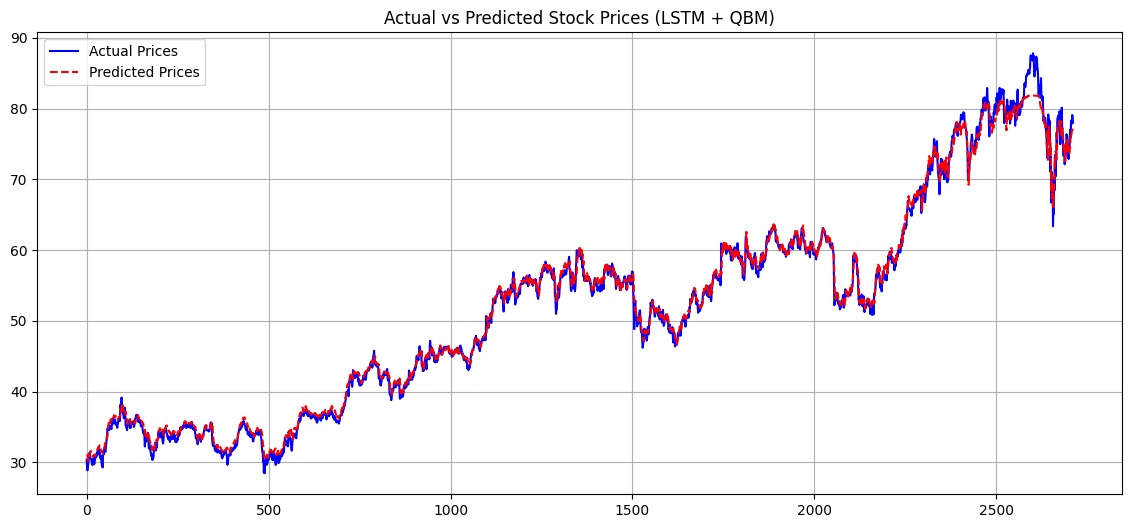

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(y_seq, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Stock Prices (LSTM + QBM)')
plt.legend()
plt.grid(True)
plt.show()